In [1]:
from pathlib import Path
import pandas as pd

import seaborn as sns
import geopandas as gpd

import matplotlib.pyplot as plt

In [10]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1. Read in the data

In [11]:
explanatory_file_path = "data/7_training_data/explanatory_with_response_var_and_source.csv"
df = pd.read_csv(explanatory_file_path)
print("lenght of df: ", len(df))
# Drop duplicates on id and date
df = df.drop_duplicates(subset=["id", "date"])
print("lenght of df after dropping duplicates: ", len(df))

# Find if there are any NaNs and remove them from the dataset 
# Some NAN values are still present in the dataset, probably due to the fact that some of the
# points fall outside bounds of GLDSA dataset
df = df[~df.isna().any(axis=1)]

print("lenght of df after droping any nan values: ", len(df))

lenght of df:  33420
lenght of df after dropping duplicates:  32577
lenght of df after droping any nan values:  31554


## 2. Add regions to the points

<center><img src="img/training_regions.png" alt="image" width="900"/></center>
<p>Below we will add the region attribute to each of the points, this will be useful if we want to train different models over different subsets.</p>

In [12]:
shp_path = Path("data/0_shp/")
region_path = "regions_to_request_explanatory_all.gpkg"
gdf_regions = gpd.GeoDataFrame.from_file(shp_path/region_path)

unique_coords = df[["id", 'lon', 'lat']].drop_duplicates()
len(df), len(unique_coords)

# Create geodataframe from x y coordinates
station_with_region_df = gpd.GeoDataFrame(unique_coords, geometry=gpd.points_from_xy(unique_coords.lon, unique_coords.lat), crs="EPSG:4326")

# # Add the region id to each point
station_with_region_df = gpd.sjoin(station_with_region_df, gdf_regions[["region_id", "geometry"]], how="left", predicate="within")

# Merge the region id to the main dataframe
df = df.merge(station_with_region_df[["id", "region_id"]], on="id", how="left")
df

,source,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,...,gldas_stddev,B3,B4,B5,B7,ndvi,ndmi,ndbri,doy,region_id
0,pkeg,02_AHL_SBG-B076,2021-06-01,-41.0,3.937760,117.007750,32.785855,-11.481278,-5.556430,0.207099,...,1.817817,21,97,61,25,0.644068,0.227848,0.590164,152,10
1,pkeg,02_AHL_SBG-B076,2021-08-24,-38.0,3.937760,117.007750,32.785295,-12.812067,-5.960235,0.201164,...,1.817817,21,97,61,25,0.644068,0.227848,0.590164,236,10
2,pkeg,02_AHL_SBG-B076,2022-04-09,-22.0,3.937760,117.007750,32.795191,-18.437775,-10.636812,0.072032,...,1.817817,33,70,96,52,0.359223,-0.156627,0.147541,99,10
3,pkeg,02_AHL_SBG-B076,2023-02-15,-31.0,3.937760,117.007750,32.793740,-13.051827,-9.007584,0.076149,...,1.817817,33,70,96,52,0.359223,-0.156627,0.147541,46,10
4,pkeg,02_AHL_SBG-B101,2021-06-01,-66.0,3.931860,117.010120,39.267563,-9.778736,-6.648683,0.111111,...,1.811218,21,75,57,25,0.562500,0.136364,0.500000,152,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31549,old_brg,kalteng1,2020-02-24,-23.9,-2.319728,114.058131,32.478706,-12.878587,-8.271499,0.097345,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,55,8
31550,old_brg,kalteng1,2020-03-07,-31.1,-2.319728,114.058131,32.478589,-13.078360,-6.593164,0.169898,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,67,8
31551,old_brg,kalteng1,2020-03-19,-14.7,-2.319728,114.058131,32.479968,-12.563061,-7.793232,0.110794,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,79,8
31552,old_brg,kalteng1,2020-03-31,-27.1,-2.319728,114.058131,32.480674,-13.179518,-7.523130,0.128794,...,3.461483,19,81,53,21,0.620000,0.208955,0.588235,91,8


## Exploratory: Get the count of the number of dates for each point

In [14]:
# group by id and get the number of dates for each id
df_grouped = df.groupby("id").count().reset_index()
df_grouped = df_grouped[["id", "date"]]
df_grouped.columns = ["id", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False)

,id,date_count
1968,BRG_150710_03,261
1957,BRG_140806_01,228
1967,BRG_150710_02,226
745,15_RAPP_PPDV-05a,212
779,15_RAPP_PPDVIII-23,206
...,...,...
896,15_RAPP_SKM/XIII-04,1
895,15_RAPP_SKM/XII-15a,1
894,15_RAPP_SKM/XII-14a,1
893,15_RAPP_SKM/XII-13,1


<Axes: xlabel='region_id', ylabel='gwl_cm'>

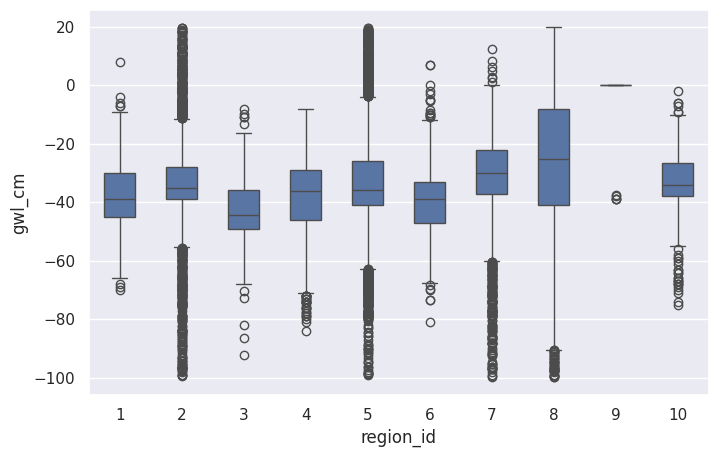

In [15]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

# 3. Identify outliers


When dealing with outliers in data, it's essential to adopt a systematic approach, and there are various statistical methods to identify and handle them. Here are some commonly used techniques to detect and remove outliers:

### Z-Score:

The Z-score represents the number of standard deviations a data point is from the mean.
Typically, if the Z-score is greater than 3 or less than -3, the data point can be classified as an outlier.


### Interquartile Range (IQR):

The IQR is the range between the first quartile (25th percentile) and the third quartile (75th percentile) of the data.
Data points that lie 1.5 times the IQR below the first quartile or above the third quartile can be classified as outliers.

### Visual Methods:

Box plots (as you've shown) can visually represent outliers.
Scatter plots can also help visualize outliers in multi-dimensional data.


### Domain Knowledge:

Sometimes, domain expertise can provide thresholds beyond which values are implausible.


### Check regions 3 and 9

In [16]:
# Create descriptive statistics
df_region_3 = df[df.region_id == 3]
df_region_9 = df[df.region_id == 9]

problematic_regions = [3, 9]

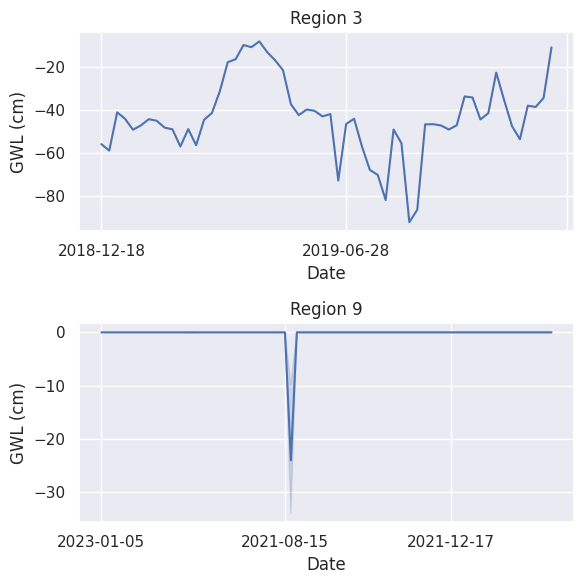

In [17]:
from matplotlib.dates import MonthLocator


# Set the figure size
fig, axs = plt.subplots(len(problematic_regions), 1, figsize=(6, 3*len(problematic_regions)))

# Iterate over the region IDs and create a separate plot for each region
for i, region_id in enumerate(problematic_regions):
    ax = axs[i]
    sns.lineplot(x="date", y="gwl_cm", data=df[df.region_id==region_id], ax=ax)
    ax.set_title(f"Region {region_id}")
    ax.set_xlabel("Date")
    ax.set_ylabel("GWL (cm)")

    # Use MonthLocator for sparse labeling
    ax.xaxis.set_major_locator(MonthLocator())


# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

## Discuss: Does the displayed values for this point make sense?

- Consider to remove any of the problematic regions.

In [18]:
df = df[~df.region_id.isin([9])]

<Axes: xlabel='region_id', ylabel='gwl_cm'>

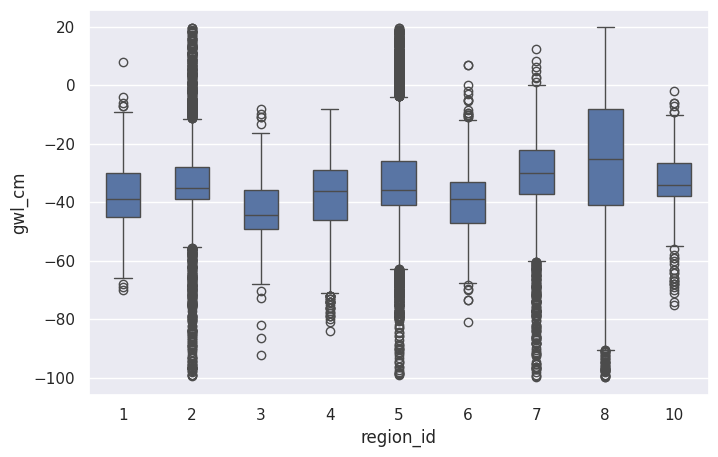

In [19]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

In [20]:
# Calculate Q1 and Q3 for each region
Q1 = df.groupby('region_id')['gwl_cm'].quantile(0.25)
Q3 = df.groupby('region_id')['gwl_cm'].quantile(0.75)

# Calculate IQR for each region
IQR = Q3 - Q1

# Define bounds for outliers for each region
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Map the lower and upper bounds for each region_id in df
df_lower_bound = df['region_id'].map(lower_bound)
df_upper_bound = df['region_id'].map(upper_bound)

# Filter out outliers
filtered_df = df[~((df['gwl_cm'] < df_lower_bound) | (df['gwl_cm'] > df_upper_bound))]
filtered_df

,source,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,...,B3,B4,B5,B7,ndvi,ndmi,ndbri,doy,region_id,percentile
0,pkeg,02_AHL_SBG-B076,2021-06-01,-41.0,3.937760,117.007750,32.785855,-11.481278,-5.556430,0.207099,...,21,97,61,25,0.644068,0.227848,0.590164,152,10,0.005855
1,pkeg,02_AHL_SBG-B076,2021-08-24,-38.0,3.937760,117.007750,32.785295,-12.812067,-5.960235,0.201164,...,21,97,61,25,0.644068,0.227848,0.590164,236,10,0.005855
2,pkeg,02_AHL_SBG-B076,2022-04-09,-22.0,3.937760,117.007750,32.795191,-18.437775,-10.636812,0.072032,...,33,70,96,52,0.359223,-0.156627,0.147541,99,10,0.005855
3,pkeg,02_AHL_SBG-B076,2023-02-15,-31.0,3.937760,117.007750,32.793740,-13.051827,-9.007584,0.076149,...,33,70,96,52,0.359223,-0.156627,0.147541,46,10,0.005855
7,pkeg,02_AHL_SBG-B101,2022-04-09,-34.0,3.931860,117.010120,39.270480,-16.941989,-10.601523,0.066845,...,34,68,101,57,0.333333,-0.195266,0.088000,99,10,0.016393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31549,old_brg,kalteng1,2020-02-24,-23.9,-2.319728,114.058131,32.478706,-12.878587,-8.271499,0.097345,...,19,81,53,21,0.620000,0.208955,0.588235,55,8,0.994688
31550,old_brg,kalteng1,2020-03-07,-31.1,-2.319728,114.058131,32.478589,-13.078360,-6.593164,0.169898,...,19,81,53,21,0.620000,0.208955,0.588235,67,8,0.994688
31551,old_brg,kalteng1,2020-03-19,-14.7,-2.319728,114.058131,32.479968,-12.563061,-7.793232,0.110794,...,19,81,53,21,0.620000,0.208955,0.588235,79,8,0.994688
31552,old_brg,kalteng1,2020-03-31,-27.1,-2.319728,114.058131,32.480674,-13.179518,-7.523130,0.128794,...,19,81,53,21,0.620000,0.208955,0.588235,91,8,0.994688


<Axes: title={'center': 'GWL distribution after percentile outlier removal'}, xlabel='region_id', ylabel='gwl_cm'>

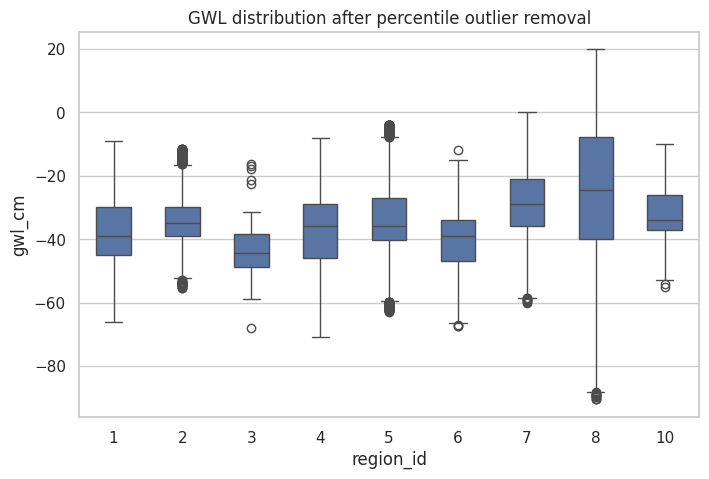

In [21]:
# set the seaborn style and size
sns.set_style("whitegrid")

# give a title
plt.title("GWL distribution after percentile outlier removal")

sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="region_id", y="gwl_cm", data=filtered_df, width=0.5)

## Question: What to do with values above 0?

- Could you explain the values above 0? how are the devices placed?

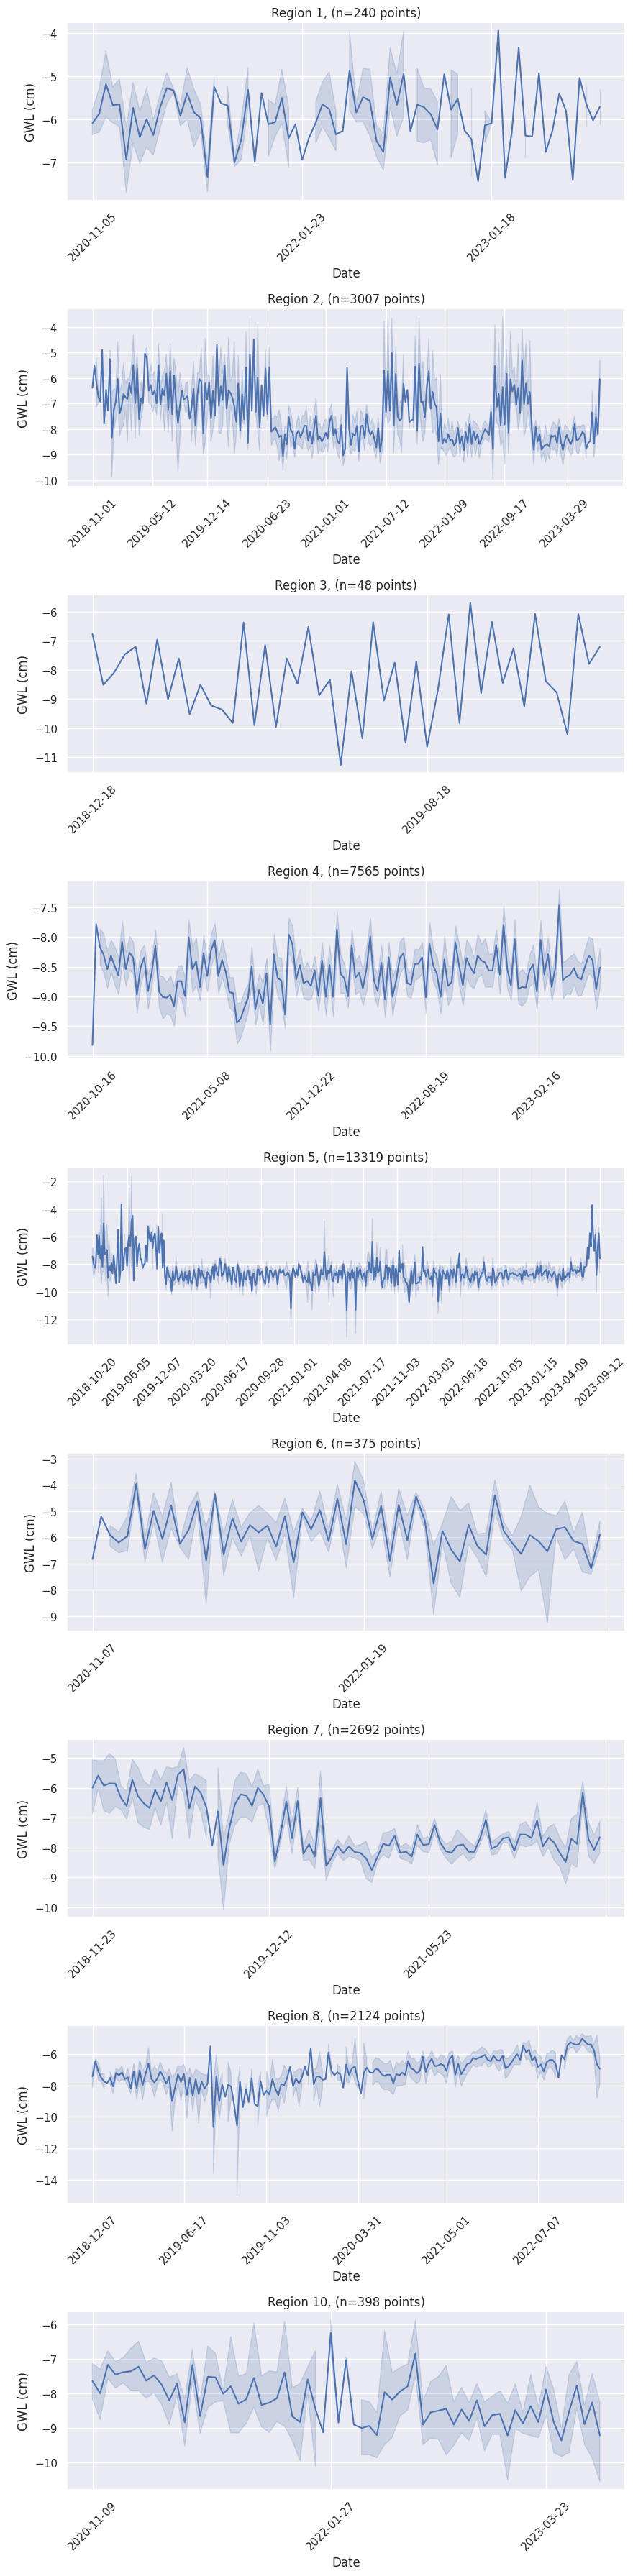

In [22]:
import matplotlib.pyplot as plt

# Get the unique region IDs
region_ids = sorted(filtered_df.region_id.unique())

# Set the figure size
fig, axs = plt.subplots(len(region_ids), 1, figsize=(9, 4*len(region_ids)))

# Iterate over the region IDs and create a separate plot for each region
for i, region_id in enumerate(region_ids):
    ax = axs[i]

    data = filtered_df[filtered_df.region_id==region_id]

    # Sort the data by date
    data = data.sort_values(by="date")

    # create a title for each plot

    sns.lineplot(x="date", y="VV", data=data, ax=ax)

    # Add number of points to the title
    ax.set_title(f"Region {region_id}, (n={len(data)} points)")
    ax.set_xlabel("Date")
    ax.set_ylabel("GWL (cm)")

    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

    # Use MonthLocator for sparse labeling
    ax.xaxis.set_major_locator(MonthLocator())

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plots
plt.show()

# 3.1 Use the Domain Knowledge to further filter the data (if required)

Visually, does this data make sense?

# 3.2 Remove 

# 4. Export the cleaned dataset to a CSV file

In [24]:
# filtered_df.to_csv("data/9_clean_training_data/clean_training_data.csv", index=False)